# Tanzanian Water Wells Status Prediction

## Overview

Tanzania is a developing country that struggles to get clean water to its population of 59 million people.  According to WHO, 1 in 6 people in Tanzania lack access to safe drinking water and 29 million don't have access to improved sanitation. The focus of this project is to build a classification model to predict the functionality of waterpoints in Tanzania given data provided by Taarifa and the Tanzanian Ministry of Water. The model was built from a dataset containing information about the source of water and status of the waterpoint (functional, functional but needs repairs, and non functional) using an iterative approach and can be found [here](./data/training_set_values.csv).  The dataset contains 60,000 waterpoints in Tanzania and the following features: 
* `amount_tsh` - Total static head (amount water available to waterpoint)
* `date_recorded` - The date the row was entered
* `funder` - Who funded the well
* `gps_height` - Altitude of the well
* `installer` - Organization that installed the well
* `longitude` - GPS coordinate
* `latitude` - GPS coordinate
* `wpt_name` - Name of the waterpoint if there is one
* `num_private` -
* `basin` - Geographic water basin
* `subvillage` - Geographic location
* `region` - Geographic location
* `region_code` - Geographic location (coded)
* `district_code` - Geographic location (coded)
* `lga` - Geographic location
* `ward` - Geographic location
* `population` - Population around the well
* `public_meeting` - True/False
* `recorded_by` - Group entering this row of data
* `scheme_management` - Who operates the waterpoint
* `scheme_name` - Who operates the waterpoint
* `permit` - If the waterpoint is permitted
* `construction_year` - Year the waterpoint was constructed
* `extraction_type` - The kind of extraction the waterpoint uses
* `extraction_type_group` - The kind of extraction the waterpoint uses
* `extraction_type_class` - The kind of extraction the waterpoint uses
* `management` - How the waterpoint is managed
* `management_group` - How the waterpoint is managed
* `payment` - What the water costs
* `payment_type` - What the water costs
* `water_quality` - The quality of the water
* `quality_group` - The quality of the water
* `quantity` - The quantity of water
* `quantity_group` - The quantity of water
* `source` - The source of the water
* `source_type` - The source of the water
* `source_class` - The source of the water
* `waterpoint_type` - The kind of waterpoint
* `waterpoint_type_group` - The kind of waterpoint

The first sections focus on investigating, cleaning, wrangling, and reducing dimensionality for modeling.  The next section contains 6 different classification models and evaluation of each, ultimately leading to us to select our best model for predicting waterpoint status based on the precision of the functional wells in the model.  Finally, I will make recommendations to the Tanzanian Government and provide insight on predicting the status of waterpoints.

## Business Problem

The Tanzanian government has a severe water crisis on their hands as a result of the vast number of non functional wells and they have asked for help. They want to be able to predict the statuses of which pumps are functional, functional but need repair, and non functional in order to improve their maintenance operations and ensure that it's residents have access to safe drinking water.  The data has been collected by and is provided by Taarifa and the Tanzanian Ministry of Water with the hope that the information provided by each waterpoint can aid understanding in which waterpoints will fail.

I have partnered with the Tanzanian government to build a classification model to predict the status of the waterpoints using the dataset provided. I will use the precision of the functional wells as my main metric for model selection, as a non functional well being predicted as a functional well would be more detrimental to their case, but will provide and discuss several metrics for each model. 

## Project Objectives

1. Fix Waterpoints in Problem Areas:

Objective: Fix at least 30% of non-working waterpoints in the regions of Mtwara, Lindi, Mara, and Rukwa within the next year.
>ie . Send repair teams to these areas, make sure resources are used effectively, and set up systems to check the status of repairs regularly.

2. Repair and Maintain Waterpoints with Water:

Objective: Repair over 8,000 waterpoints that have water but are not working, and fix all the waterpoints needing repairs in Kigoma within 18 months.
>ie. Create and follow a plan to repair these waterpoints, start with those that already have water, and schedule regular checks to keep them working.

3. Improve Installer Performance and Payment:

Objective: Reduce pump failures caused by the government, district councils, and Fini Water by 25% in the next year.
>ie. Review why these installers have high failure rates, consider using different installers if needed, and look at how payment affects maintenance. Improve training and incentives for installers based on these findings.

## Data Understanding

The dataset used for this analysis can be found [here](./data/training_set_values.csv).  It contains a wealth of information about waterpoints in Tanzania and the status of their operation.  The target variable has 3 different options for it's status:
* `functional` - the waterpoint is operational and there are no repairs needed
* `functional needs repair` - the waterpoint is operational, but needs repairs
* `non functional` - the waterpoint is not operational

Below I will import the dataset and start my investigation of relevant information it may contain.  Let's get started! 

In [5]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#import xgboost as xgb
from sklearn.dummy import DummyClassifier
#from xgboost.sklearn import XGBClassifier

from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Scalers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize

# Categorical Create Dummies
from sklearn.preprocessing import OneHotEncoder

In [6]:
# Data Import Train Set
df_train_set = pd.read_csv('.\Data\Training set values.csv', index_col='id')
df_train_set

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


In [7]:
# Data import Training set labels
df_train_labels = pd.read_csv('.\Data\Training set labels.csv', index_col='id')
df_train_labels

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
...,...
60739,functional
27263,functional
37057,functional


In [8]:
#Merge datasets
df = pd.merge(df_train_labels, df_train_set, how = 'inner', on='id')

In [9]:
#Reset index
df.reset_index(inplace=True)
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [10]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [11]:
#Get stats on numeric columns
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [12]:
#Check for duplicates
sum(df.duplicated())

0

In [13]:
# Print all value counts to make observations
for col in df.columns:
    print(df[col].value_counts())

2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2012-01-21      1
2011-09-19      1
2011-09-08      1
2002-10-14      1
2011-09-15      1
Name: date_recorded, Length: 356, dtype: int64
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rdws                         1
Mh.J S

In [14]:
# Check null values
df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [15]:
# Check unique values for categorical data
obj_df = df.select_dtypes(include=['object'])
obj_df.nunique()

status_group                 3
date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
subvillage               19287
region                      21
lga                        125
ward                      2092
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

### Initial Observations

#### Missing Values

__scheme_name__ has the most missing values, followed by __funder__, __installer__,  __public_meeting__, __scheme_management__,  and __permit__ with ~3,000 null values, and then __subvillage__ with 371 null values.  Several of these columns will be deleted as they appear to duplicate other columns, and I will investigate __installer__, __permit__, and __subvillage__ further.

#### Data types

* __wpt_name__, __subvillage__, __ward__, __scheme_name__, __installer__, __funder__, and __date_recorded__ are categorical features that have unique values in the thousands.  This will be a problem with dummy variables, will likely remove or feature engineer. 
* I will drop __recorded_by__ as it has the same value for all rows.
* __num_private__ is not defined on the DrivenData site, and it is not obvious what the feature indicates. 
* __id__ column will be dropped.
* __public_meeting__ and __permit__ are boolean.
* __construction_year__, __latitude__, __longitude__, __gps_height__, __amount_tsh__, and __population__ all have thousands of rows of 0 entered.  I will drop rows for most of these variables that have 0 entered, and will have to investigate further for real data on some columns.  
 
#### Duplicate  and Similar Data
 
The following columns all contain duplicate or similar data, will remove features that will cause multicollinearity:
* __extraction_type__, __extraction_type_group__, and __extraction_type_class__
* __payment__ and __payment_type__
* __water_quality__ and __quality_group__ 
* __quanitity__ and __quantity_group__
* __source__ and __source_type__
* __waterpoint_type__ and __waterpoint_type_group__
* __region__ and __region_code__

## Data Cleaning

In this section, I will clean the dataset by removing similar and unnecessary columns and trim the dataset of remaining null values.  I will also further investigate whether some columns contain the same information if it was not immediately obvious.  There are several rows containing 0 enteries in some column information.  I will investigate whether I believe the data to be real instead of a placeholder.

### Drop duplicate and columns with similar information

I will keep __extraction_type_class__ and remove __extraction_type__ and __extraction_type_group__ as it's columns values appear to be the most relevant for the project. __scheme_name__ will be dropped for it's many null values.  Other columns will be removed at this point due to irrelavancy, duplicates, null values, and some others will have to be investigated after the first drop.

In [16]:
# Columns to be dropped
dropped_columns = ['extraction_type', 'extraction_type_group', 'payment', 'scheme_name', 'quality_group',
                   'quantity_group', 'source', 'waterpoint_type_group', 'recorded_by', 'num_private', 
                   'id', 'subvillage', 'wpt_name', 'ward', 'funder', 'date_recorded', 'public_meeting', 
                   'region_code', 'district_code', 'lga', 'scheme_management', 'source_class']

In [17]:
df = df.drop(dropped_columns, axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   region                 59400 non-null  object 
 8   population             59400 non-null  int64  
 9   permit                 56344 non-null  object 
 10  construction_year      59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management             59400 non-null  object 
 13  management_group       59400 non-null  object 
 14  payment_type           59400 non-null  object 
 15  wa

### Dealing with null values

In [19]:
#Check for nulls
df.isna().sum()

status_group                0
amount_tsh                  0
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
region                      0
population                  0
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

In [20]:
# Drop all remaining null values from our dataset
df = df.dropna()

In [21]:
#Check to see that it worked
df.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management               0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type          0
dtype: int64

In [22]:
# Convert boolean permit to integers
df['permit'] = df['permit'].astype(int)

In [23]:
# Check to see that it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55102 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           55102 non-null  object 
 1   amount_tsh             55102 non-null  float64
 2   gps_height             55102 non-null  int64  
 3   installer              55102 non-null  object 
 4   longitude              55102 non-null  float64
 5   latitude               55102 non-null  float64
 6   basin                  55102 non-null  object 
 7   region                 55102 non-null  object 
 8   population             55102 non-null  int64  
 9   permit                 55102 non-null  int32  
 10  construction_year      55102 non-null  int64  
 11  extraction_type_class  55102 non-null  object 
 12  management             55102 non-null  object 
 13  management_group       55102 non-null  object 
 14  payment_type           55102 non-null  object 
 15  wa

### Investigate management and management_group

I need to investigate these 2 columns further to see if they contain similar information.

In [24]:
df['management'].value_counts()

vwc                 37416
wug                  6314
water board          2705
wua                  2307
private operator     1891
parastatal           1588
water authority       825
other                 733
company               656
unknown               491
other - school         99
trust                  77
Name: management, dtype: int64

In [25]:
df['management_group'].value_counts()

user-group    48742
commercial     3449
parastatal     1588
other           832
unknown         491
Name: management_group, dtype: int64

The most data is contained in the user-group subcategory of __management_group__.  I will groupby to investigate if the information is similar.

In [26]:
df.loc[df['management_group']=='user-group']['management'].value_counts()

vwc            37416
wug             6314
water board     2705
wua             2307
Name: management, dtype: int64

The data is identical to the data contained in the management column in the subcategory of 'user-group'.  I will drop __management_group__ from our features.

In [27]:
#Drop column
df = df.drop('management_group', axis=1)

In [28]:
#Check to see that it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55102 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           55102 non-null  object 
 1   amount_tsh             55102 non-null  float64
 2   gps_height             55102 non-null  int64  
 3   installer              55102 non-null  object 
 4   longitude              55102 non-null  float64
 5   latitude               55102 non-null  float64
 6   basin                  55102 non-null  object 
 7   region                 55102 non-null  object 
 8   population             55102 non-null  int64  
 9   permit                 55102 non-null  int32  
 10  construction_year      55102 non-null  int64  
 11  extraction_type_class  55102 non-null  object 
 12  management             55102 non-null  object 
 13  payment_type           55102 non-null  object 
 14  water_quality          55102 non-null  object 
 15  qu

In [29]:
for col in df.columns:
    print(df[col].value_counts())

functional                 29885
non functional             21381
functional needs repair     3836
Name: status_group, dtype: int64
0.0        37811
500.0       3071
50.0        2333
1000.0      1442
20.0        1427
           ...  
38000.0        1
1400.0         1
8500.0         1
6300.0         1
26.0           1
Name: amount_tsh, Length: 95, dtype: int64
 0       18310
-15         54
 303        51
-16         51
-13         50
         ...  
 2424        1
 2405        1
 2628        1
 2552        1
 2576        1
Name: gps_height, Length: 2426, dtype: int64
DWE                   17361
Government             1788
RWE                    1203
Commu                  1060
DANIDA                 1049
                      ...  
Birage                    1
ter                       1
SDA CHURCH                1
Water use Group           1
Pentecostal church        1
Name: installer, Length: 2056, dtype: int64
0.000000     1793
32.984790       2
37.540901       2
37.328905       2
37.2

After our first round of cleaning, there are several features we need to examine further:
* __status_group__ is an unbalanced target, may need to look into further during modeling and apply SMOTE.
* There are several columns with thousands of 0 entries - __amount_tsh__, __gps_height__, __longitude__, __latitude__, __population__, __construction_year__.

### Construction year

In [30]:
df['construction_year'].value_counts()

0       18392
2008     2568
2009     2490
2010     2427
2000     1565
2007     1557
2006     1447
2003     1276
2011     1211
2004     1107
2002     1064
1978     1027
2012     1025
2005      983
1995      978
1999      950
1985      941
1998      921
1984      777
1996      766
1982      741
1972      705
1994      703
1974      675
1990      666
1980      647
1992      632
1997      612
1993      595
2001      530
1988      520
1983      487
1975      437
1986      431
1976      411
1991      322
1989      316
1970      310
1987      297
1981      237
1977      199
1979      192
1973      183
2013      173
1971      145
1963       84
1967       83
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

In [31]:
# Finding mean and median without zero values
df.loc[df['construction_year']!=0].describe()

,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year
count,36710.000000,36710.000000,36710.000000,36710.000000,36710.000000,36710.000000,36710.000000
mean,471.881843,982.395015,36.015003,-6.358975,268.881694,0.717379,1996.888096
std,3074.841656,623.784917,2.609370,2.762486,542.812926,0.450280,12.452883
min,0.000000,-63.000000,29.607122,-11.649440,0.000000,0.000000,1960.000000
25%,0.000000,351.000000,34.671850,-8.855908,30.000000,0.000000,1987.000000
50%,0.000000,1116.500000,36.691907,-6.351197,150.000000,1.000000,2000.000000
75%,200.000000,1471.000000,37.896261,-3.731978,304.000000,1.000000,2008.000000
max,250000.000000,2770.000000,40.345193,-1.042375,30500.000000,1.000000,2013.000000


In [32]:
#Replace 0 values in construction_year with 1950 to aid visualization
df['construction_year'].replace(to_replace = 0, value = 1950, inplace=True)

In [33]:
#Check to see if it worked
df['construction_year'].value_counts()

1950    18392
2008     2568
2009     2490
2010     2427
2000     1565
2007     1557
2006     1447
2003     1276
2011     1211
2004     1107
2002     1064
1978     1027
2012     1025
2005      983
1995      978
1999      950
1985      941
1998      921
1984      777
1996      766
1982      741
1972      705
1994      703
1974      675
1990      666
1980      647
1992      632
1997      612
1993      595
2001      530
1988      520
1983      487
1975      437
1986      431
1976      411
1991      322
1989      316
1970      310
1987      297
1981      237
1977      199
1979      192
1973      183
2013      173
1971      145
1963       84
1967       83
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

It is unfortunate that there are 19,000 entries with 0 for the __construction_year__.  These may be natural and spring fed sources that were never "constructed".  I chose to replace the 0 values with 1950, so they are still the "oldest" in the dataset, but will aid in visualizing the functionality of the pumps by the year they were made.

### Latitude/Longitude zeros

In [34]:
df.longitude.value_counts()

0.000000     1793
32.984790       2
37.540901       2
37.328905       2
37.252194       2
             ... 
39.002868       1
37.095964       1
36.658462       1
33.116994       1
38.592731       1
Name: longitude, Length: 53261, dtype: int64

In [35]:
# Investigate longitude entries that are 0
df.loc[df['longitude'] == 0]

,status_group,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source_type,waterpoint_type
21,functional,0.0,0,DWE,0.0,-2.000000e-08,Lake Victoria,Shinyanga,0,0,1950,handpump,wug,unknown,unknown,unknown,shallow well,hand pump
53,non functional,0.0,0,Government,0.0,-2.000000e-08,Lake Victoria,Mwanza,0,1,1950,submersible,vwc,unknown,unknown,dry,borehole,communal standpipe multiple
168,functional,0.0,0,WVT,0.0,-2.000000e-08,Lake Victoria,Shinyanga,0,0,1950,gravity,parastatal,other,soft,seasonal,rainwater harvesting,communal standpipe
177,non functional,0.0,0,DWE,0.0,-2.000000e-08,Lake Victoria,Shinyanga,0,0,1950,other,wug,unknown,soft,enough,shallow well,other
253,functional needs repair,0.0,0,DWE,0.0,-2.000000e-08,Lake Victoria,Mwanza,0,1,1950,handpump,vwc,never pay,soft,insufficient,shallow well,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,functional needs repair,0.0,0,DWE,0.0,-2.000000e-08,Lake Victoria,Shinyanga,0,0,1950,handpump,wug,other,soft,enough,shallow well,hand pump
59208,functional,0.0,0,DWE,0.0,-2.000000e-08,Lake Victoria,Shinyanga,0,0,1950,handpump,wug,unknown,soft,enough,shallow well,hand pump
59295,functional needs repair,0.0,0,DWE,0.0,-2.000000e-08,Lake Victoria,Shinyanga,0,0,1950,handpump,wug,never pay,soft,enough,shallow well,hand pump
59324,functional,0.0,0,World Vision,0.0,-2.000000e-08,Lake Victoria,Shinyanga,0,0,1950,handpump,wug,unknown,soft,enough,shallow well,hand pump


The 0s that are entered into the longitude column are also 0s in gps_height and -2e8 for latitude columns.  I will drop these values from the dataset.

In [36]:
# Drop rows with 0 entered in longitude column
df = df.loc[df['longitude'] != 0]

In [37]:
# Check to see if it worked
df.describe()

,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year
count,53309.000000,53309.000000,53309.000000,53309.000000,53309.000000,53309.000000,53309.000000
mean,337.580181,692.509670,35.186804,-5.849440,188.814515,0.702508,1982.288394
std,2714.547122,691.264883,2.670974,2.806529,474.147131,0.457159,24.045731
min,0.000000,-90.000000,29.607122,-11.649440,0.000000,0.000000,1950.000000
25%,0.000000,0.000000,33.167340,-8.441371,0.000000,0.000000,1950.000000
50%,0.000000,438.000000,35.295878,-5.144420,45.000000,1.000000,1989.000000
75%,40.000000,1322.000000,37.353028,-3.359390,240.000000,1.000000,2005.000000
max,250000.000000,2770.000000,40.345193,-0.998464,30500.000000,1.000000,2013.000000


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53309 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           53309 non-null  object 
 1   amount_tsh             53309 non-null  float64
 2   gps_height             53309 non-null  int64  
 3   installer              53309 non-null  object 
 4   longitude              53309 non-null  float64
 5   latitude               53309 non-null  float64
 6   basin                  53309 non-null  object 
 7   region                 53309 non-null  object 
 8   population             53309 non-null  int64  
 9   permit                 53309 non-null  int32  
 10  construction_year      53309 non-null  int64  
 11  extraction_type_class  53309 non-null  object 
 12  management             53309 non-null  object 
 13  payment_type           53309 non-null  object 
 14  water_quality          53309 non-null  object 
 15  qu

Looks like it all worked!  I believe the __amount_tsh__ and __population__ 0 values are real so I will leave all data as is for vanilla models.

### Installer - Several different spellings for same installer

In [39]:
#Check unique values after inital cleaning
df.nunique()

status_group                 3
amount_tsh                  95
gps_height                2426
installer                 2024
longitude                53260
latitude                 53262
basin                        9
region                      21
population                1026
permit                       2
construction_year           55
extraction_type_class        7
management                  12
payment_type                 7
water_quality                8
quantity                     5
source_type                  7
waterpoint_type              7
dtype: int64

Upon checking the unique values for our categorical variables after trimming the dataset, installer still has 2024 unique entries, which will be a problem when we create dummies.  We will need to cut down the amount of unique entries to not overload our model.

In [40]:
#Investigate 2024 unique values for installer
# pd.set_option("display.max_rows", None)
df['installer'].value_counts()

DWE                     16214
Government               1633
RWE                      1178
Commu                    1060
DANIDA                   1049
                        ...  
Hilfe Fur Bruder            1
ter                         1
Mama Kapwapwa               1
Ramadhani M. Mvugalo        1
Pentecostal church          1
Name: installer, Length: 2024, dtype: int64

There are several entries with typos and different variations of the same installer. I will attempt to fix some of the clerical errors and narrow down the amount of unique identifiers we will use for our model.

In [41]:
# Correct variations and misspellings in the installer column
df['installer'] = df['installer'].replace(to_replace = ('Central government', 'Tanzania Government',
                                          'Cental Government','Tanzania government','Cebtral Government', 
                                          'Centra Government', 'central government', 'CENTRAL GOVERNMENT', 
                                          'TANZANIA GOVERNMENT','Central govt', 'Centr', 'Centra govt', 
                                          'Tanzanian Government', 'Tanzania'), value = 'Central Government')

df['installer'] = df['installer'].replace(to_replace = ('District COUNCIL', 'DISTRICT COUNCIL',
                                          'Counc','District council','District Counci', 
                                          'Council', 'COUN', 'Distri', 'District  Council'), 
                                          value = 'District Council')

df['installer'] = df['installer'].replace(to_replace = ('villigers', 'villager', 'villagers', 'Villa', 'Village',
                                          'Villi', 'Village Council', 'Village Counil', 'Villages', 'Vill', 
                                          'Village community', 'Villaers', 'Village Community', 'Villag',
                                          'Villege Council', 'Village council', 'Village Council', 'Villagerd', 
                                          'Villager', 'Village Technician', 'Village Office', 'VILLAGE COUNCIL',
                                          'Village community members', 'VILLAG', 'Village Government', 
                                          'Village govt', 'VILLAGERS', 'Village  Council'), value ='Villagers')

df['installer'] = df['installer'].replace(to_replace = ('District Water Department', 'District water depar',
                                          'Distric Water Department'), value ='District water department')

df['installer'] = df['installer'].replace(to_replace = ('FinW', 'Fini water', 'FINI WATER', 'FIN WATER',
                                          'Finwater', 'FINN WATER', 'FinW', 'FW', 'FinWater', 'FiNI WATER'), 
                                          value ='Fini Water')

df['installer'] = df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC', 'RC Ch', 'RC C', 'RC CH',
                                          'RC church', 'RC CATHORIC', 'Ch') , value ='RC Church')

df['installer'] = df['installer'].replace(to_replace = ('world vision', 'World Division', 'World vision', 
                                          'WORLD VISION', 'World Vission'), value ='World Vision')

df['installer'] = df['installer'].replace(to_replace = ('Unisef','Unicef'), value ='UNICEF')

df['installer'] = df['installer'].replace(to_replace = 'DANID', value ='DANIDA')

df['installer'] = df['installer'].replace(to_replace =('Commu', 'Communit', 'commu', 'COMMU', 'COMMUNITY', 
                                          'Adra /Community', 'Communit', 'Adra/Community', 'Adra/ Community'), 
                                          value ='Community')

df['installer'] = df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM', 'GOVERN',
                                          'Gover', 'Gove', 'Governme', 'Governmen'), value ='Government')

df['installer'] = df['installer'].replace(to_replace = ('Hesawa', 'hesawa'), value ='HESAWA')

df['installer'] = df['installer'].replace(to_replace = ('JAICA', 'JICA', 'Jica', 'Jeica', 'JAICA CO'), 
                                          value ='Jaica')

df['installer'] = df['installer'].replace(to_replace = ('KKKT _ Konde and DWE', 'KKT', 'KKKT Church', 'KkKT'), 
                                          value ='KKKT')

df['installer'] = df['installer'].replace(to_replace = '0', value ='Unknown')

In [42]:
df['installer'].value_counts().head(20)

DWE                   16214
Government             2468
Community              1791
DANIDA                 1601
HESAWA                 1180
RWE                    1178
District Council       1173
Central Government     1115
KKKT                   1102
Fini Water              952
Unknown                 780
TCRS                    702
World Vision            660
CES                     610
RC Church               484
Villagers               482
LGA                     408
WEDECO                  397
TASAF                   371
Jaica                   358
Name: installer, dtype: int64

### Reduce Dimensionality for Installer

In [43]:
# Keep only top 20 installers as unique values
installer_20 = df.installer.value_counts(normalize=True).head(20).index.tolist()  


df['installer'] = [type_ if type_ in installer_20
                      else "OTHER" for type_ in df['installer']]

In [44]:
df.installer.value_counts()

OTHER                 19283
DWE                   16214
Government             2468
Community              1791
DANIDA                 1601
HESAWA                 1180
RWE                    1178
District Council       1173
Central Government     1115
KKKT                   1102
Fini Water              952
Unknown                 780
TCRS                    702
World Vision            660
CES                     610
RC Church               484
Villagers               482
LGA                     408
WEDECO                  397
TASAF                   371
Jaica                   358
Name: installer, dtype: int64

To reduce the dimensionality of the dataset, I made an "Other" category for installer if they were not in the top 20 installers of the dataset.

## Modified Features Exploration

### Column EDA

#### Target Feature Distribution

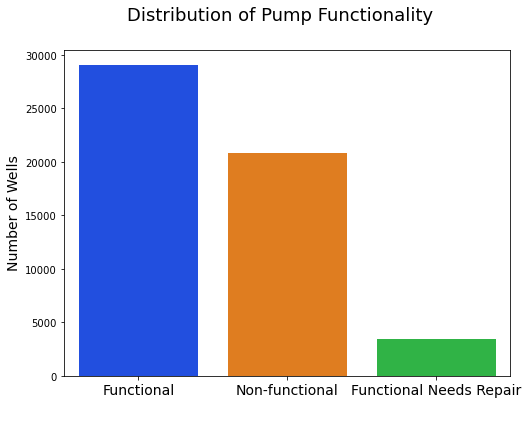

In [45]:
# plot
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(x='status_group', palette='bright', data=df)

# Title and y-axis labels
fig.suptitle('Distribution of Pump Functionality', fontsize=18)
plt.ylabel('Number of Wells', fontsize=14)
plt.xlabel(' ', fontsize=14)

# X Labels
labels = ['Functional', 'Non-functional', 'Functional Needs Repair']
plt.xticks(ticks=(0,1,2), labels = labels, rotation = 0, size = 14)

plt.show();

In [46]:
# Numner of wells in each category
df['status_group'].value_counts()

functional                 29026
non functional             20829
functional needs repair     3454
Name: status_group, dtype: int64

We have the most functional wells at ~29,000, followed by non functional wells at ~21,000, and the minority class, functional needs repair at ~3,500.

#### Construction year

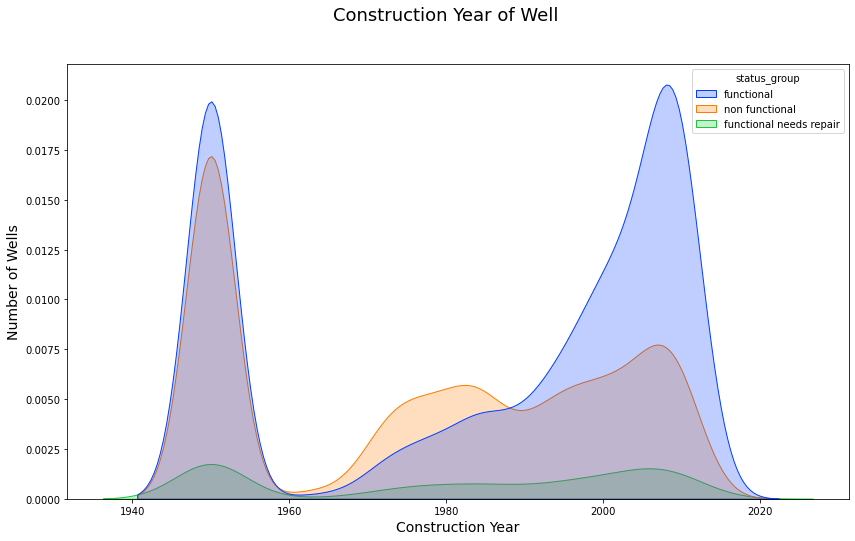

In [47]:
# Plot
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.kdeplot(data=df, x='construction_year', hue='status_group', palette='bright', fill=True)

# Title and axis labels
fig.suptitle('Construction Year of Well', fontsize=18)
plt.xlabel("Construction Year", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)
plt.show();

There is large amount of data in the year 1950 which were entered as 0 in the dataset, these may be natural sources and our distribution is normal for these sources.  However, we can see the correlation of an older pump being more likely to be non functional and more functional newer pumps.

In [48]:
# Create df without entries in year 1950
const_year_df = df.loc[df['construction_year'] != 1950]

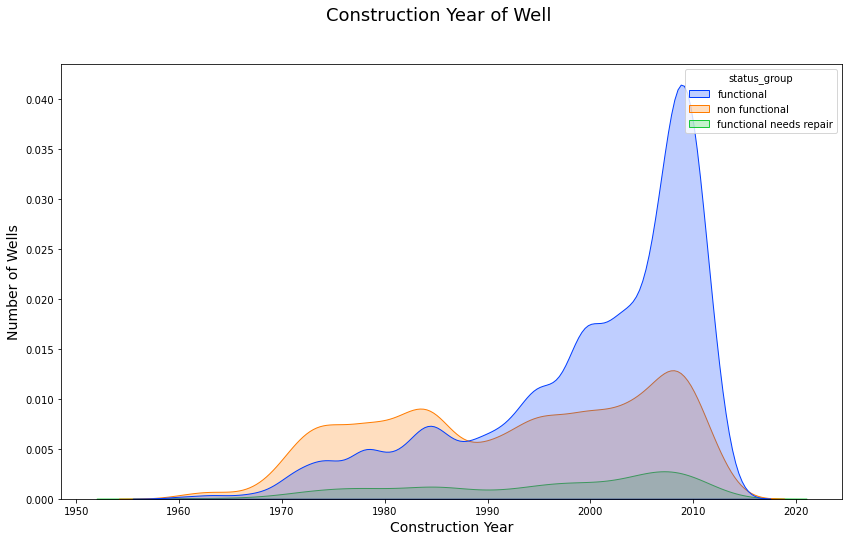

In [49]:
# Plot without waterpoints from year 1950
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.kdeplot(data=const_year_df, x='construction_year', hue='status_group', palette='bright', fill=True)

# Title and axis labels
fig.suptitle('Construction Year of Well', fontsize=18)
plt.xlabel("Construction Year", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)

plt.show();

There are more non functional pumps than functional if they were built before 1988, but the rate of functionality keeps increasing after 1988.

#### Population

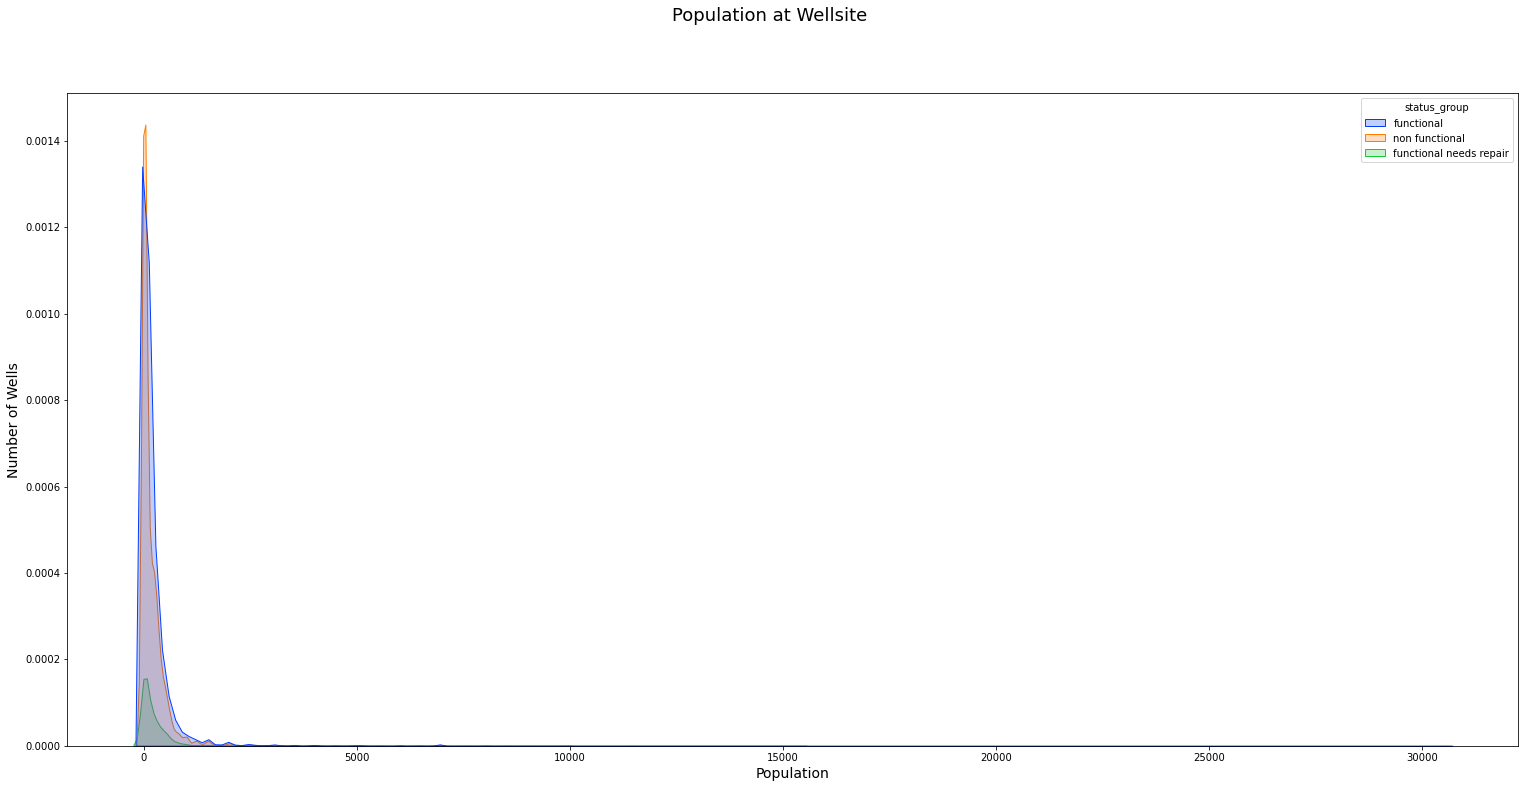

In [50]:
# Plot
fig, ax = plt.subplots(figsize=(26,12))
ax = sns.kdeplot(data=df, x='population', hue='status_group', palette='bright', fill=True)

# Title and axis labels
fig.suptitle('Population at Wellsite', fontsize=18)
plt.xlabel("Population", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)
plt.show()

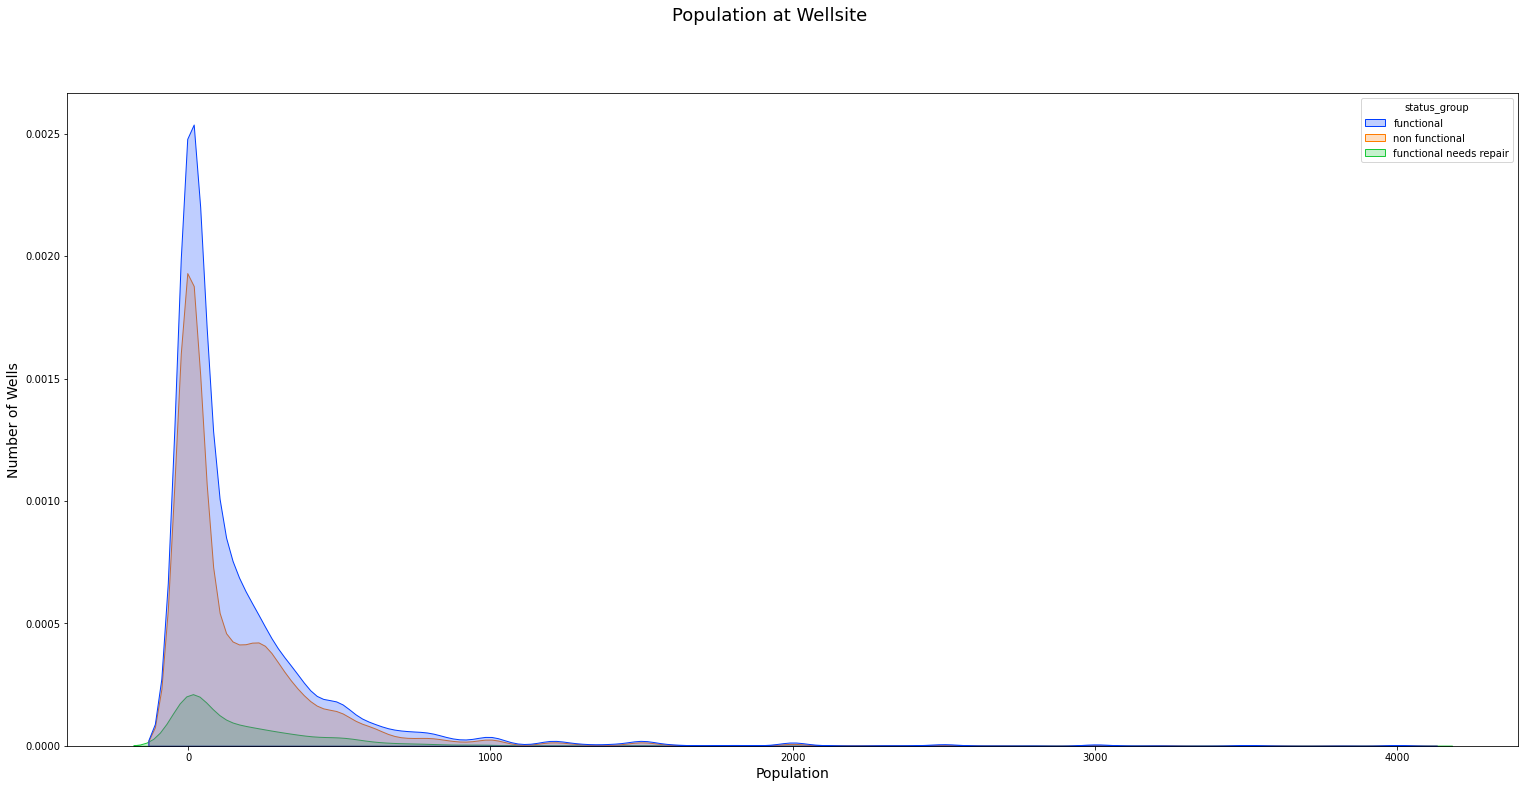

In [51]:
# Get a closer look
pop_df = df.loc[df['population'] <= 4000]

# Plot
fig, ax = plt.subplots(figsize=(26,12))
ax = sns.kdeplot(data=pop_df, x='population', hue='status_group', palette='bright', fill=True)

# Title and axis labels
fig.suptitle('Population at Wellsite', fontsize=18)
plt.xlabel("Population", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)
plt.show()

Overall, the distribution of pump functionality is similar across all population ranges and there isn't a lot of separation, with there being more functional wells than any other class.  There isn't too much to draw from these graphs about population and functionality.

#### Extraction_type_class

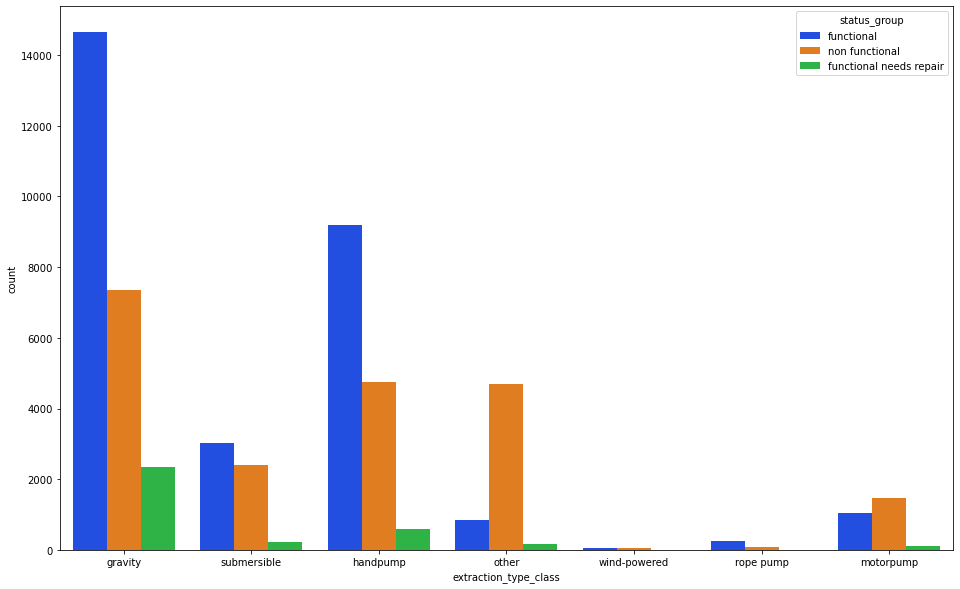

In [52]:
# Plot
plt.figure(figsize=(16,10))
ax = sns.countplot(x='extraction_type_class', hue='status_group', palette='bright', data=df);

Other type and motorpump are especially non functioning.  Gravity and handpump are the 2 largest types, and both have more functioning, but half non functioning.

#### Management

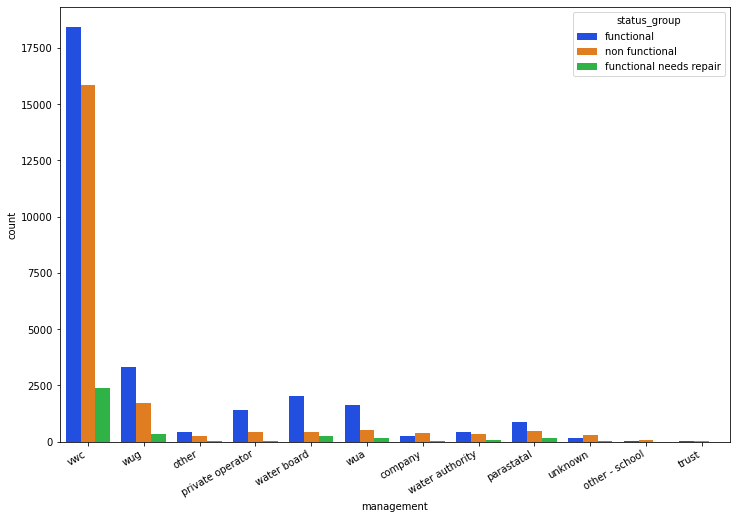

In [53]:
# Plot
plt.figure(figsize=(12,8))
ax = sns.countplot(x='management', hue='status_group', palette='bright', data=df)
plt.xticks(rotation=30, ha='right');

water board, wua, and private operators have a high rate of functionality.

#### Payment_type

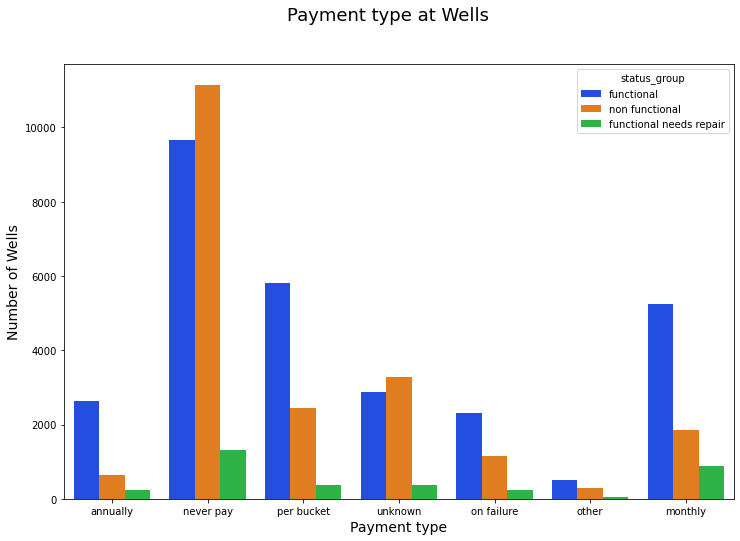

In [54]:
# Plot
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='payment_type', hue="status_group", palette='bright', data=df)

# Title and axis labels
fig.suptitle('Payment type at Wells', fontsize=18)
plt.xlabel("Payment type", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)
plt.show();

Never pay pumps have more non functioning waterpoints than functioning waterpoints. Some form of payment increases the functionality of the waterpoints.

#### Water quality

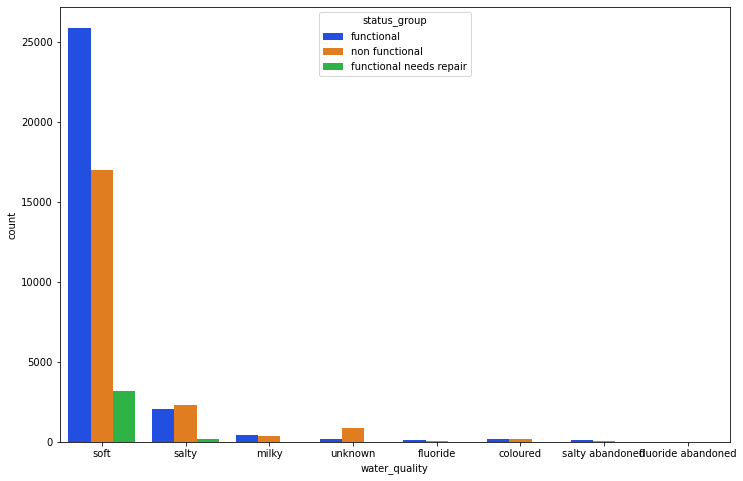

In [55]:
# Plot
plt.figure(figsize=(12,8))
ax = sns.countplot(x='water_quality', hue='status_group', palette='bright', data=df);

Soft water quality has a high rate of functional waterpoints, salty has a high rate of non functional waterpoints.

#### Source type

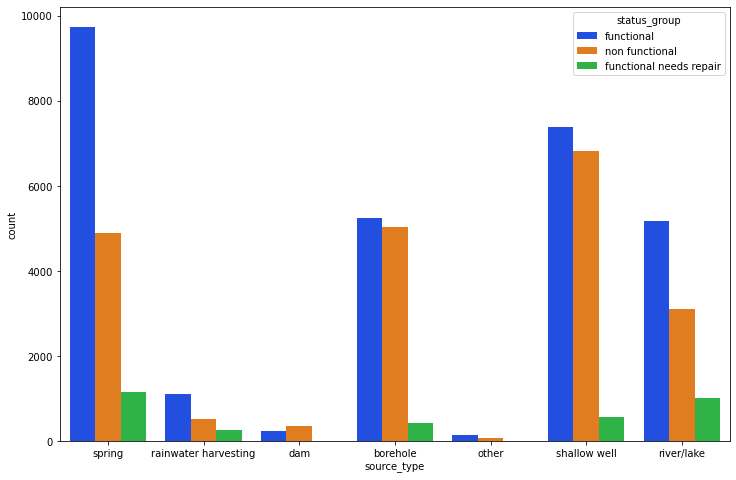

In [56]:
# Plot
plt.figure(figsize=(12,8))
ax = sns.countplot(x='source_type', hue='status_group', palette='bright', data=df);

Even distribution of functional and nonfunctional boreholes.  Many more functional springs and rivers than non functional.

#### Basin

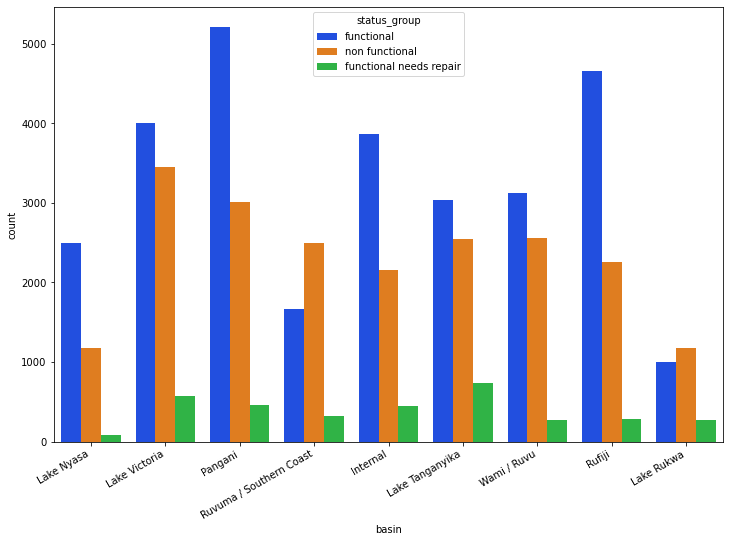

In [57]:
# Plot
plt.figure(figsize=(12,8))
ax = sns.countplot(x='basin', hue='status_group', palette='bright', data=df)
plt.xticks(rotation=30, ha='right');

The Ruvuma/Southern Coast and Lake Rukwa basins have more non functioning wells than functional.  

#### Quantity

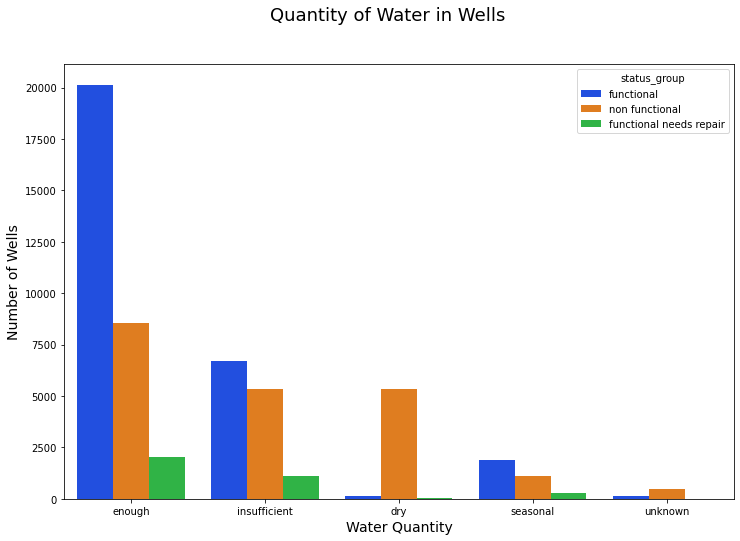

In [58]:
# Plot
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='quantity', hue="status_group", palette='bright', data=df)

# Axis and title
fig.suptitle('Quantity of Water in Wells', fontsize=18)
plt.xlabel("Water Quantity", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)

plt.show();

Dry waterpoints have a high chance of being non functional, as expected.  If the waterpoint has enough water, there is a high chance of functionality.

The Iringa region has a very high rate of functioning wells, followed by Kilimanjaro, Arusha, and Shinyanga.  The worst regions for well perfomance are Mtwara, Mara, Rukwa,  and Lindi.

#### Waterpoint type

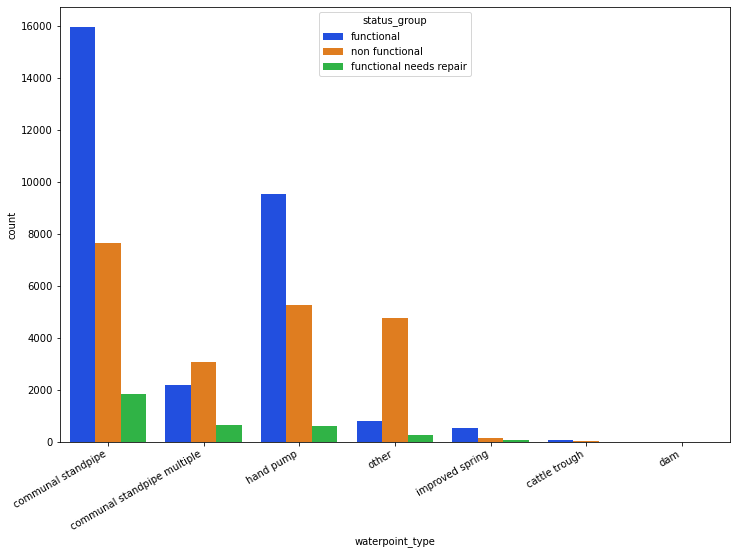

In [59]:
# Plot
plt.figure(figsize=(12,8))
ax = sns.countplot(x='waterpoint_type', hue='status_group', palette='bright', data=df)
plt.xticks(rotation=30, ha='right');

Other and communal standpipe multiple have the highest rate of being non functioning.

#### Installer

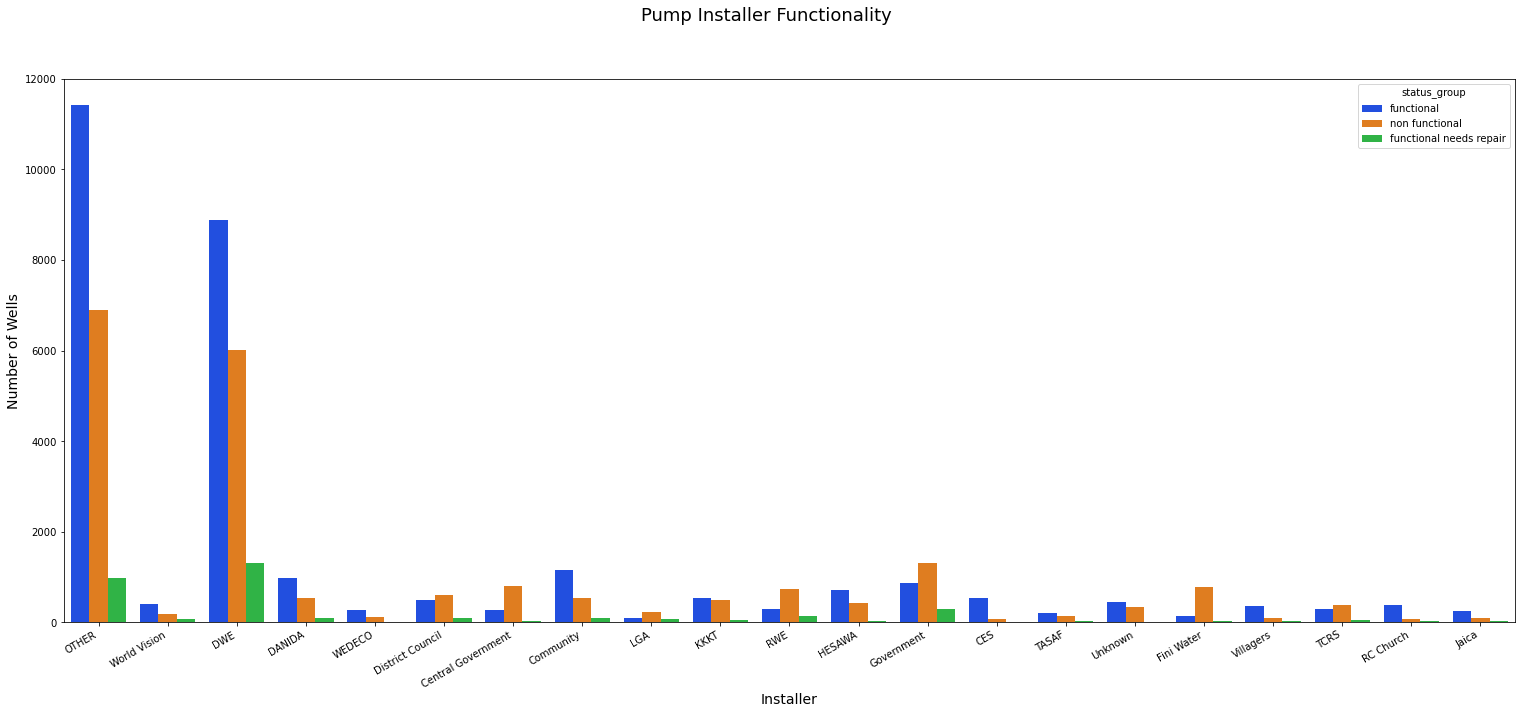

In [60]:
# Plot
fig, ax = plt.subplots(figsize=(26,10))
ax = sns.countplot(x='installer', hue="status_group", palette='bright', data=df)

# Title and axis labels
fig.suptitle('Pump Installer Functionality', fontsize=18)
plt.xlabel("Installer", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)
# Rotate x labels
plt.xticks(rotation=30, ha='right')

plt.show();

The government, Fini Water, RWE, and Distict Council have a high rate of non functioning wells.  Other is out largest category.

### Well Function map

In [61]:
# Import packages
import folium
from folium.plugins import FloatImage

In [62]:
# Create 3 dataframes for each status_group
df_f = df[df['status_group'] == 'functional']
df_nf = df[df['status_group'] == 'non functional']
df_fnr = df[df['status_group'] == 'functional needs repair']

In [63]:
# Create lists of latitude and longitude values
lat_f = [x for x in df_f['latitude']]
long_f = [x for x in df_f['longitude']]

lat_nf = [x for x in df_nf['latitude']]
long_nf = [x for x in df_nf['longitude']]

lat_fnr = [x for x in df_fnr['latitude']]
long_fnr = [x for x in df_fnr['longitude']]

lat_long_f = [(lat_f[i], long_f[i]) for i in range(len(lat_f))]
lat_long_nf = [(lat_nf[i], long_nf[i]) for i in range(len(lat_nf))]
lat_long_fnr = [(lat_fnr[i], long_fnr[i]) for i in range(len(lat_fnr))]

### Create df['status'] with status_group  in integer format

In [64]:
# Change status_group/target values to numeric values
df['status'] = df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})
df.head()

,status_group,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source_type,waterpoint_type,status
0,functional,6000.0,1390,OTHER,34.938093,-9.856322,Lake Nyasa,Iringa,109,0,1999,gravity,vwc,annually,soft,enough,spring,communal standpipe,2
1,functional,0.0,1399,OTHER,34.698766,-2.147466,Lake Victoria,Mara,280,1,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,2
2,functional,25.0,686,World Vision,37.460664,-3.821329,Pangani,Manyara,250,1,2009,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,2
3,non functional,0.0,263,OTHER,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,1,1986,submersible,vwc,never pay,soft,dry,borehole,communal standpipe multiple,0
4,functional,0.0,0,OTHER,31.130847,-1.825359,Lake Victoria,Kagera,0,1,1950,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,2


In [65]:
df = df.drop('status_group', axis=1)

## Modeling

### Data Preprocessing

Following we will create our dummy variables for our categorical columns and perform train test split to prepare for modeling.

#### Create dummies

In [66]:
# Create lists of categorical and continuous columns
cat_col = ['installer','basin','region','extraction_type_class','management','payment_type','water_quality',
           'quantity','source_type','waterpoint_type']
cont_col = ['amount_tsh','gps_height','longitude','latitude','population','permit','construction_year']

In [67]:
#Create dummies
dummy_df = pd.get_dummies(df,columns=cat_col,drop_first=True)


#### Separate target and perform train test split

In [68]:
y = dummy_df['status']
X = dummy_df.drop(['status'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Statistics Function

Precision will be our main metric used to track model performance, but we will calculate accuracy, recall, and f1 score to provide more detail using sklearn's _classification_report()_ function.

In [69]:
# function to track model metrics and plot confusion matrix

def model_score(model, X, y_pred, y_true):
    target_names= ['non func', 'func need repair', 'functional']
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    #Confusion matrix    
    return plot_confusion_matrix(model, X, y_true, display_labels=target_names);

### Dummy Classifier Model

In [70]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state=42)
dummy.fit(X_train, y_train)
print(dummy.score(X_test, y_test))



0.5471768898893266


Our baseline dummy model performed very poorly with an accuracy score of 46%.  Our data is heavily imbalanced, which explains how our ternary model performed close to 50%.

### Logistic Regression

In [71]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression


# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
logreg.fit(X_train, y_train)


LogisticRegression(random_state=0, solver='liblinear')

In [72]:
y_pred_test = logreg.predict(X_test)

y_pred_test

array([2, 0, 0, ..., 0, 2, 0], dtype=int64)

Our logistic regression model is improved to 75% accuracy over the dummy model.  This model struggled to predict wells that were functional but needed repairs, likely due to class imbalances. The precision of the functional class is 73%.

In [73]:
# probability of getting output as 0 - no rain

logreg.predict_proba(X_test)[:,0]

array([0.07636396, 0.97446781, 0.5685986 , ..., 0.99509324, 0.11839079,
       0.85914157])

## Check accuracy score

In [74]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.7471


In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71      4157
           1       0.60      0.04      0.08       671
           2       0.73      0.90      0.81      5834

    accuracy                           0.75     10662
   macro avg       0.71      0.53      0.53     10662
weighted avg       0.74      0.75      0.72     10662



In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the pipeline
pipe_lr = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])

# Fit the model
pipe_lr.fit(X_train, y_train)

# Predict on the test set
test_preds = pipe_lr.predict(X_test)

# Calculate the accuracy score
lr_score = accuracy_score(y_test, test_preds)

print("Test data model score:", lr_score)


Test data model score: 0.7499531044832114


### Decision Tree Model

In [86]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz

# Train a Decision Tree classifier
dc = DecisionTreeClassifier()
dc.fit(X_train, y_train)




DecisionTreeClassifier()

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create the pipeline
pipe_dt = Pipeline([
    ('ss', StandardScaler()), 
    ('dt', DecisionTreeClassifier())
])

# Fit the model
pipe_dt.fit(X_train, y_train)

# Predict on the test set
test_preds = pipe_dt.predict(X_test)

# Calculate the accuracy score
dt_score = accuracy_score(y_test, test_preds)

print("Test data model score:", dt_score)


Test data model score: 0.7549240292628024


In [82]:
# Predict on training and test sets
training_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 75.49%


In [87]:
# Binarize for multiclass problem
y_multi_test = label_binarize(y_test, classes=[0, 1, 2])

# Predict probability for each model
dt_model_pred_proba = pipe_dt.predict_proba(X_test)
log_model_pred_proba = pipe_lr.predict_proba(X_test)



# Calculate AUC ROC score using predicted probablity for each model
dt_test = roc_auc_score(y_multi_test, dt_model_pred_proba, multi_class='ovr')
log_model_auc = roc_auc_score(y_multi_test, log_model_pred_proba, multi_class='ovr')


print(f'The AUC score for our decision tree model is: {round(dt_test, 4)}')
print(f'The AUC score for our logistic regression model is: {round(log_model_auc, 4)}')

The AUC score for our decision tree model is: 0.7475
The AUC score for our logistic regression model is: 0.8309


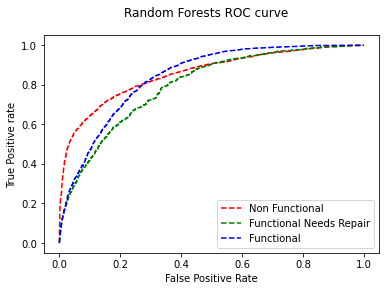

In [90]:
# Plot
fig, ax = plt.subplots()

# Create dictionary
n_class = 3

fpr = {}
tpr = {}
thresh ={}

# Iterate through each class to create roc_curve
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, log_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Non Functional')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Functional Needs Repair')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Functional')
plt.suptitle('Random Forests ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

## Conclusions

Data Utilization and Model Improvement

Analyze Key Features:

>Water Quantity: Since water quantity has proven crucial, ensure models account for this feature effectively.
Payment Models: Investigate how payment influences functionality. Develop and promote strategies to implement or enhance fee structures to encourage regular maintenance.
Address Non-Functional Waterpoints with Water:

>Prioritize over 8,000 non-functional waterpoints with sufficient water as they represent immediate opportunities for restoration with existing resources.
Improve Data Quality:

>Future Data Collection: Ensure that data collected moving forward is accurate and comprehensive. This will enhance the reliability of predictions and recommendations.
Continuous Monitoring and Updating: Regularly monitor the status of wells and update your models accordingly. This will help in refining predictions and adapting strategies.

# Recommedation 

>Prioritize Critical Areas:

Southeast (Mtwara, Lindi), North (Mara), and Southwest (Rukwa): Focus on these regions where the rate of non-functional waterpoints is high. Immediate intervention is crucial due to the severity of the situation.

>Assess and Repair Functional But Needing Maintenance Points: 

Kigoma: Address the cluster of functional waterpoints needing repair to prevent costly future failures.

> Investigate and Improve Installer Performance:

Government, District Council, and Fini Water: Conduct a thorough review of why these entities have higher failure rates. Potential issues could include quality of installation, maintenance practices, or training deficits.